# Preprocessing and descriptive statistics

In this notebook we did preprocessing of the raw data and did descriptive statistics on the pre-processed data to support our project proposal in MS2.
We did the following pipeline for preprocessing and descriptive statistics.

1. We filtered the base dataset we will use for this project so that it only contains quotations from US policitians or world-wide politicians.
2. We interpreted the dumped data's QIDs into meaningful words.
3. 
did some initial analysis and descriptive statistics of the base dataset we will use for this project

# Required package
[json](https://docs.python.org/3/library/json.html)
[bz2](https://docs.python.org/3/library/bz2.html)
[pandas](https://pandas.pydata.org/)
[matplotlib](https://matplotlib.org/)
[qwikidata](https://qwikidata.readthedocs.io/en/stable/)
# Required data
[wikidata dump](https://dumps.wikimedia.org/wikidatawiki/entities/)

In [3]:
import time
import json
import bz2
import sys
from qwikidata.entity import WikidataItem
from qwikidata.json_dump import WikidataJsonDump
from qwikidata.utils import dump_entities_to_json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, OrderedDict
import re

## 1 Dumping politicians from wikidata
This part filtered from the full wikidata dump politician entitities and dumped useful labels into a compressed json file. The script works in the pipeline:

1. Load the wikidata dump in stream mode with qwikidata package
2. Go through item's dictionary and filtered data of interest
3. Dump the data into a compressed json file and print debug information ('corrupted fields in wikidata dumps') The script differs from the provided query_wikidata_dump.py in that
4. The dumped data only considers alive people.
5. The dumped data only considers politicians.
6. The dumped data provides the start/end data of held positions.

In [2]:
WIKI_DATA_FULL = '../../latest-all.json.bz2' #path to wiki data dump
WIKI_DATA_FILTERED = '../../filtered_politician_v2.json.bz2' #path to filtered wiki data dump
WIKI_DATA_FILTERED_LABELED = '../../filtered_politician_labeled_v2.json.bz2' #path to filtered wikidata with interpretations
WIKI_DATA_FILTERED_MISSINGQ = '../../filtered_politician_missingqids_v2.json.bz2'  #path to missing QIDs in small catalogue gile
#politician ID in wikidata
Q_POLITICIAN = "Q82955" 
#property IDs in wikidata
P_OCCUPATION = "P106"
P_COUNTRY = "P27"
P_POSITION_HELD = "P39"
P_GENDER = "P21"
P_CITIZENSHIP = "P27"
P_RELIGION = "P140"
P_US_CONGRESS_ID = "P1157"
P_CANDIDACY = "P3602"
P_PARTY = "P102"
P_START_TIME = "P580"
P_END_TIME = "P582"
P_DEAD = "P570"

In [3]:
def has_occupation_politician(item: WikidataItem, truthy: bool = True) -> bool:
    """Return True if the Wikidata Item has occupation politician. Adapted from template of qwikidata property query"""
    # Might also be interesting to filter millitary officers (Q189290). (not implemented here)
    if truthy:
        claim_group = item.get_truthy_claim_group(P_OCCUPATION)
    else:
        claim_group = item.get_claim_group(P_OCCUPATION)
    occupation_qids = [
        claim.mainsnak.datavalue.value["id"]
        for claim in claim_group
        if claim.mainsnak.snaktype == "value"
    ]
    return Q_POLITICIAN in occupation_qids #return if Q_POLITICIAN appears in P_OCCUPATION values

In [ ]:
# create an instance of WikidataJsonDump
wjd_dump_path = WIKI_DATA_FULL
wjd = WikidataJsonDump(wjd_dump_path)

# create an iterable of WikidataItem representing politicians
politicians = []
t1 = time.time()
with bz2.open(WIKI_DATA_FILTERED, 'wb') as d_file:
    for ii, entity_dict in enumerate(wjd):
        if entity_dict["type"] == "item":
            entity = WikidataItem(entity_dict)
            try:
                if has_occupation_politician(entity):
                    if (P_DEAD not in entity_dict['claims'].keys() 
                        and P_CITIZENSHIP in entity_dict['claims'].keys()):
                        try:
                            temp_position_held = []
                            temp_parties = []
                            temp_usid = ""
                            temp_religion = ""
                            temp_aliases= []
                            temp_candiacy = []
                            #position held and start/end time(optinal field)
                            if (P_POSITION_HELD in entity_dict['claims'].keys()):
                                for v in entity_dict["claims"][P_POSITION_HELD]:
                                    temp_qualifiers = []
                                    if (v["mainsnak"].get("datavalue", {}).get("value", {}).get("id") is not None):
                                        temp_qualifiers.append(v['mainsnak']['datavalue']['value']['id'])#position held
                                        try:
                                            temp_qualifiers.append(v['qualifiers'][P_START_TIME][0]['datavalue']['value']['time'])#start time
                                        except:
                                            temp_qualifiers.append("")
                                        try:
                                            temp_qualifiers.append(v['qualifiers'][P_END_TIME][0]['datavalue']['value']['time'])#start time
                                        except:
                                            temp_qualifiers.append("")
                                    temp_position_held.append(temp_qualifiers)
                            #Party members (optinal field)
                            if (P_PARTY in entity_dict['claims'].keys()):
                                for v in entity_dict["claims"][P_PARTY]:
                                    if (v["mainsnak"].get("datavalue", {}).get("value", {}).get("id") is not None):
                                        temp_parties.append(v['mainsnak']['datavalue']['value']['id']) #parties held **NOTE: there could be people switching parties but wiki doesn't give any temporal information
                            #Candidacy in election (optinal field)
                            if (P_CANDIDACY in entity_dict['claims'].keys()):
                                for v in entity_dict["claims"][P_CANDIDACY]:
                                    if (v["mainsnak"].get("datavalue", {}).get("value", {}).get("id") is not None):
                                        temp_candiacy.append(v['mainsnak']['datavalue']['value']['id']) 
                            # US Congress Bio ID (optinal field)
                            if (P_US_CONGRESS_ID in entity_dict['claims'].keys()):#there are some corrupted data on wikidata with this field but no data
                                if ('datavalue' in entity_dict['claims'][P_US_CONGRESS_ID][0]['mainsnak']):
                                    temp_usid = entity_dict["claims"][P_US_CONGRESS_ID][0]['mainsnak']['datavalue']['value']
                            # Religion (optinal field)
                            if (P_RELIGION in entity_dict['claims'].keys()):
                                temp_religion = entity_dict["claims"][P_RELIGION][0]['mainsnak']['datavalue']['value']['id']
                            #aliases (optional field)
                            
                            if ("aliases" in entity_dict.keys()):
                                if len(entity_dict.get("aliases", {}).get("en", [])) > 0:
                                    for v in entity_dict["aliases"]["en"]:
                                        temp_aliases.append(v["value"])
                            #qid, name, gender, nationality are compulsory fields
                            politicians.append(dict(zip(['qid',
                                                         'name',
                                                         'gender',
                                                         'nationality',
                                                         'aliases',
                                                         'parties',
                                                         'positions held',
                                                         'religion',
                                                         'us_congress_id',
                                                         'candidacy_election'],
                                                        [entity_dict['id'],#Qid
                                                         entity_dict['labels']['en']['value'], #name
                                                         entity_dict['claims'][P_GENDER][-1]['mainsnak']['datavalue']['value']['id'], #latest gender
                                                         entity_dict['claims'][P_CITIZENSHIP][-1]['mainsnak']['datavalue']['value']['id'], #latest country of citizenship
                                                         temp_aliases,
                                                         temp_parties,
                                                         temp_position_held,
                                                         temp_religion,
                                                         temp_usid,
                                                         temp_candiacy
                                                        ])))# dump entity qid, name and nationality only
                        except KeyError as e: #missing important keys (name, qid, country, gender)
                            print(e,entity_dict['id'])
            except Exception:
                print (Exception)
        if ii % 20000 == 0:
            t2 = time.time()
            dt = t2 - t1
            print(
                "Dumped {} politicians among {} entities [entities/s: {:.2f}]".format(
                    len(politicians), ii, ii / dt
                )
            )
            d_file.write(('\n'.join(map(json.dumps, politicians))+'\n').encode('utf-8'))
            politicians = []

The [filtering](https://github.com/epfl-ada/ada-2021-project-date-a-data/blob/main/Milestone2/filter_quotations.ipynb) will take 10 hrs to re-run so we leave it in the notebook where it was executed.

In [4]:
df = pd.read_json(WIKI_DATA_FILTERED, lines=True, compression='bz2')
print(f'Filtered {len(df)} politician records in total')

Filtered 269337 politician records in total


## 2 QIDs Interpretation

This part interpreted the qids in the filtered politician entity dump from the small quotebank qid catalogue.
The script works in the pipeline:
1. Load the filtered wikidata json dump in chunks
2. Go through record's columns and interpret the QIDs from the label field in the catalogue.
3. The interpretation is done in 3 ways
    <br>single qid interpretation (gender)<br>
    list qid interpretation (candidacy_election, parties)<br>
    list in list qid interpretation (position_held)
4. Dump the interpretated entities into a new json file
5. Dump the unrecognized QIDs into a log file

In [5]:
#specification of dataset reading parameters and folders path 
QUOTEBANK_POLITICIANS_USA=  'quotebank_politicians_USA.json.bz2' # US politician quotes
WIKI_DATA_FILTERED_LABELED = '../../filtered_politician_labeled_v2.json.bz2' # filtered wikidata with interpretations
POLITICIANS_MENTIONS_USA= 'politicians_mentions_USA.json.bz2'#
QUOTEBANK_POLITICIANS_USA_MAPPED = 'quotebank_politicians_USA_mapped.json.bz2'

In [6]:
Q_catalogue = pd.read_csv('../../wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
# this is not enough for all interpretation; need full!!

Here we defined three interpret functions for df.apply to extract qids for
1. single qid interpretation (gender)
2. list qid interpretation (candidacy_election, parties)
3. list in list qid interpretation (position_held)

In [9]:
def single_interpret(x):
    """
    Function for single value interpretation. e.g. qid Record undocumented QIDs if not already recorded.
    """
    try:
        return Q_catalogue.loc[x]['Label']
    except KeyError as e:
        if (x not in Unrecorded_Q):
            Unrecorded_Q.append(x)
        return x
def list_interpret(x):
    """
    Function for list interpretation. e.g. [qid1,qid2] Record undocumented QIDs if not already recorded.
    """
    tmp = []
    for i in x:
        try:
            tmp.append(Q_catalogue.loc[i]['Label'])
        except KeyError as e:
            tmp.append(i)
            if (i not in Unrecorded_Q):
                Unrecorded_Q.append(i)
    return tmp
def listlist_interpret(x):
    """
    Function for list interpretation. e.g. [[qid1,time1-1,time1-2],[qid2,time2-1,time2-2] Record undocumented QIDs if not already recorded.
    """
    tmp = []
    for i in x:
        tmp1 = []
        try:
            tmp1.append(Q_catalogue.loc[i[0]]['Label'])
        except KeyError as e:
            tmp.append(i[0])
            if (i[0] not in Unrecorded_Q):
                Unrecorded_Q.append(i[0])
        tmp1.append(i[1:2])
        tmp.append(tmp1)
    return tmp


In [12]:
CHUNKSIZE = 10000
Unrecorded_Q = []
with bz2.open(WIKI_DATA_FILTERED_LABELED, 'wb') as out_path_labeled:
    with bz2.open(WIKI_DATA_FILTERED_MISSINGQ, 'wb') as out_path_missingq:
        with pd.read_json(WIKI_DATA_FILTERED, lines=True, compression='bz2', chunksize=CHUNKSIZE) as df_reader:
            for chunk in df_reader:
                t1=time.time()
                chunk['gender'] = chunk['gender'].apply(single_interpret)
                chunk['parties'] = chunk['parties'].apply(list_interpret)
                chunk['candidacy_election'] = chunk['candidacy_election'].apply(list_interpret)
                #chunk['religion'] = chunk['religion'].apply(list_interpret)
                #religion property in wikipedia is messed up with instances like churches, shrines etc. better filter this another way
                try:
                    chunk['positions held'] = chunk['positions held'].apply(listlist_interpret)
                except:
                    chunk['positions held'] = chunk['positions held'].apply(list_interpret)
                chunk.to_json(path_or_buf=out_path_labeled,orient='records',lines=True)
                t2=time.time()
                dt=t2-t1
                print("Interpreted {} records and found {} undocumented qids [records/s: {:.2f}]".format(CHUNKSIZE,len(Unrecorded_Q), CHUNKSIZE / dt))
            pd.DataFrame(Unrecorded_Q).to_json(path_or_buf=out_path_missingq,orient='records',lines=True)

Interpreted 10000 records and found 3418 undocumented qids [records/s: 6184.60]
Interpreted 10000 records and found 5127 undocumented qids [records/s: 6918.81]
Interpreted 10000 records and found 15559 undocumented qids [records/s: 2556.90]
Interpreted 10000 records and found 29334 undocumented qids [records/s: 704.49]
Interpreted 10000 records and found 30301 undocumented qids [records/s: 5676.16]
Interpreted 10000 records and found 41719 undocumented qids [records/s: 462.67]
Interpreted 10000 records and found 50504 undocumented qids [records/s: 940.55]
Interpreted 10000 records and found 51566 undocumented qids [records/s: 3957.33]
Interpreted 10000 records and found 56791 undocumented qids [records/s: 538.32]
Interpreted 10000 records and found 66978 undocumented qids [records/s: 601.98]
Interpreted 10000 records and found 74167 undocumented qids [records/s: 249.36]
Interpreted 10000 records and found 75039 undocumented qids [records/s: 2581.66]
Interpreted 10000 records and found 

In [13]:
print(f'Found {len(Unrecorded_Q)} undocumented qids in total, which need to be queryed with full wikidata label catalogue. #NOTE: Religion field is not interpreted here.')

Found 123801 undocumented qids in total, which need to be queryed with full wikidata label catalogue. #NOTE: Religion field is not interpreted here.


## 3 Quote Parsing

This part parsed the quotes in filtered US political quotations and found out all mentions that include other US politician(s).
The original quote dataframe will be extended by a column in which the mentioned politician's QID(s) is/are saved in a list.
The script works in the pipeline:
1. Load the filtered and interpreted political quotations wikidata json dump in chunks.
2. Load the filtered US politicians dump.
3. Concatenate the names and aliases of the filtered US politicians dump and flatten the names. Index the names with index of politician it belongs to.
4. Create a match pattern with all US politicians.
5. Use match pattern to search all the quotations and filter out quotations containing aliases of politicians.
6. In the filtered quotations in 5., query the index of politician names in the flattened name lists in 2., look up the QID of the mentioned politician in 2.
7. Extend the dataframe by one column containing the mentions_qid data and dump them to a mapped USA quotation file.

In [16]:
#specification of dataset reading parameters and folders path 
QUOTEBANK_POLITICIANS_USA=  'quotebank_politicians_USA.json.bz2' # US politician quotes
WIKI_DATA_FILTERED_LABELED = '../../filtered_politician_labeled_v2.json.bz2' # filtered wikidata with interpretations
POLITICIANS_MENTIONS_USA= 'politicians_mentions_USA.json.bz2'#
QUOTEBANK_POLITICIANS_USA_MAPPED = 'quotebank_politicians_USA_mapped.json.bz2'
#qids_df=pd.read_json(WIKI_DATA_FILTERED_LABELED, lines=True)
Q_catalogue = pd.read_csv('../../wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
# this is not enough; need full!!

In [17]:
#extract US politicians
politician_df=pd.read_json(WIKI_DATA_FILTERED_LABELED, lines=True)
politician_us_df = politician_df[politician_df['nationality']=='Q30'] 

#extract qid, name, aliases
names_us=politician_us_df[['qid','name','aliases']] 
names_us['aliases_all'] = [a+[b] for a,b in zip(names_us['aliases'],names_us['name'])]

#concatenate and flattened aliases for pattern extraction
names_us_list = names_us['aliases_all'].tolist()
names_us_reset = names_us.reset_index(drop=True)
aliases_list = [item for sublist in names_us_list for item in sublist] 

#but save original index before flatenning
aliases_index = [names_us_list.index(sublist) for sublist in names_us_list for item in sublist] 
pattern = '|'.join(aliases_list)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_32136/2342345903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names_us['aliases_all'] = [a+[b] for a,b in zip(names_us['aliases'],names_us['name'])]


In [19]:
#extraction of political name's mention from the quotes
CHUNKSIZE=10000
try:
    os.remove(POLITICIANS_MENTIONS_USA)
except:
    pass
total_time,total_mentions,chunk_number,nb_quote=0,0,0,0
mentions=[]
with bz2.open(POLITICIANS_MENTIONS_USA, 'wb') as bzout_mention_usa:
    with pd.read_json(QUOTEBANK_POLITICIANS_USA, lines=True, chunksize=CHUNKSIZE, compression='bz2' ) as df_reader:
        for chunk in df_reader:
            t1=time.time()
            quotations_with_mentions = chunk[chunk.quotation.str.contains(pattern)]
            quotations_with_mentions.to_json(path_or_buf=bzout_mention_usa,orient='records',lines=True)
            mentions = len(quotations_with_mentions)
            total_mentions += mentions
            t2=time.time()
            dt=t2-t1
            total_time+=dt
            chunk_number += 1
            print("Dumped {} US political quotations containing mentioning of other US politicians out of {} quotations [quotations/s: {:.2f}]".format(mentions, CHUNKSIZE, CHUNKSIZE / dt))

Dumped 715 US political quotations containing mentioning of other US politicians out of 10000 quotations [quotations/s: 240.07]
Dumped 671 US political quotations containing mentioning of other US politicians out of 10000 quotations [quotations/s: 244.42]
Dumped 697 US political quotations containing mentioning of other US politicians out of 10000 quotations [quotations/s: 234.33]
Dumped 689 US political quotations containing mentioning of other US politicians out of 10000 quotations [quotations/s: 233.30]
Dumped 687 US political quotations containing mentioning of other US politicians out of 10000 quotations [quotations/s: 247.28]
Dumped 676 US political quotations containing mentioning of other US politicians out of 10000 quotations [quotations/s: 244.00]
Dumped 693 US political quotations containing mentioning of other US politicians out of 10000 quotations [quotations/s: 236.59]
Dumped 675 US political quotations containing mentioning of other US politicians out of 10000 quotations

In [20]:
print(f'Found {total_mentions} US political quotations containing mentioning of other US politicians in {total_time:0.1f} s.')

Found 27156 US political quotations containing mentioning of other US politicians in 1649.3 s.


We defined 2 functions for df.apply to append mentioned politician's qid to lists

In [21]:
def qid_list_interpret(x):
    """
    Function for qid_list interpretation. e.g. [qid1,qid2] 
    """
    tmp = []
    for i in x:
        new_qid = names_us_reset['qid'][aliases_index[i]]
        if new_qid not in tmp:
            tmp.append(new_qid)
    return tmp
def qid_interpret(x):
    """
    Function for qid interpretation. Need whole qid catalogue to work!!
    """
    tmp = []
    for i in x:
        try:
            tmp.append(Q_catalogue.loc[i]['Label'])
        except KeyError as e:
            tmp.append(i)
    return tmp

In [22]:
#mapping the speaker to the mentioned politicians
try:
    os.remove(QUOTEBANK_POLITICIANS_USA_MAPPED)
except:
    pass
CHUNKSIZE = 1000
total_time,chunk_number=0,0
with bz2.open(QUOTEBANK_POLITICIANS_USA_MAPPED, 'wb') as bzout_mention_usa:
    with pd.read_json(POLITICIANS_MENTIONS_USA, lines=True, compression='bz2', chunksize = CHUNKSIZE) as df_reader:
        for chunk in df_reader:
            t1=time.time()
            data_output = chunk
            data_output['mentions'] = np.empty((len(data_output), 0)).tolist()
            data_output['mentions_qids'] = np.empty((len(data_output), 0)).tolist()
            for i, e in enumerate(aliases_list):
                data_output.loc[data_output['quotation'].str.contains(e)]['mentions'].apply(lambda x: x.append(i))
                data_output['mentions_qids'] = data_output['mentions'].apply(qid_list_interpret)
            data_output.to_json(path_or_buf=bzout_mention_usa,orient='records',lines=True)
            t2=time.time()
            dt=t2-t1
            total_time+=dt
            chunk_number += 1
            print("Mapped {} US political mentionings to the mentioned politicians.  [quotations/s: {:.2f}]".format(chunk_number*CHUNKSIZE, CHUNKSIZE / dt))

Mapped 1000 US political mentionings to the mentioned politicians.  [quotations/s: 4.77]
Mapped 2000 US political mentionings to the mentioned politicians.  [quotations/s: 4.85]
Mapped 3000 US political mentionings to the mentioned politicians.  [quotations/s: 4.82]
Mapped 4000 US political mentionings to the mentioned politicians.  [quotations/s: 4.93]
Mapped 5000 US political mentionings to the mentioned politicians.  [quotations/s: 5.02]
Mapped 6000 US political mentionings to the mentioned politicians.  [quotations/s: 4.84]
Mapped 7000 US political mentionings to the mentioned politicians.  [quotations/s: 4.92]
Mapped 8000 US political mentionings to the mentioned politicians.  [quotations/s: 4.95]
Mapped 9000 US political mentionings to the mentioned politicians.  [quotations/s: 5.00]
Mapped 10000 US political mentionings to the mentioned politicians.  [quotations/s: 4.95]
Mapped 11000 US political mentionings to the mentioned politicians.  [quotations/s: 5.06]
Mapped 12000 US pol

And here we visualize the result. The parsed mentioned politician's qid is included in column "mentions_qids"

In [15]:
pd.read_json(QUOTEBANK_POLITICIANS_USA_MAPPED, lines=True, compression='bz2' ).head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mentions,mentions_qids
0,2020-02-07-012379,but [ President ] Trump (was) eager to make a ...,President Donald Trump,[Q22686],2020-02-07 23:05:05,1,"[[President Donald Trump, 0.5698], [None, 0.43...",[http://uspolitics.einnews.com/article/5092030...,E,[11746],[Q22686]
1,2020-01-29-019304,"Even if it's all true, exactly in the worst-ca...",Kevin Cramer,[Q3957020],2020-01-29 01:01:16,1,"[[Kevin Cramer, 0.8789], [None, 0.1072], [John...",[https://www.washingtonexaminer.com/opinion/go...,E,"[23467, 23473, 41263]","[Q6279, Q311269]"
2,2020-01-02-019876,I enjoy your analysis and instruction on polli...,Steve Bartlett,[Q185480],2020-01-02 00:00:00,1,"[[Steve Bartlett, 0.9232], [None, 0.0754], [Pr...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E,"[11746, 11751]",[Q22686]
3,2020-01-27-036296,"If your last name was not Biden, do you think ...",Joe Biden,[Q6279],2020-01-27 14:33:49,14,"[[Joe Biden, 0.6878], [None, 0.133], [Pam Bond...",[https://www.nytimes.com/live/2020/impeachment...,E,[23467],[Q6279]
4,2020-04-09-027891,"In short, the Clinton administration's policy ...",President Bill Clinton,[Q1124],2020-04-09 17:54:15,1,"[[President Bill Clinton, 0.7325], [None, 0.24...",[https://www.globalresearch.ca/911-truth-under...,E,[23453],[Q1124]


# 4 Descriptive Analysis

## Required data
Filtered politicians from Quotebank for USA and WORLD. We keep these datasets in a [Google Drive](https://drive.google.com/drive/folders/1DQkcSq3slTHJSZT_PYHw01rOk4X6e2Q2) since they make 1.5Gb and 3Gb respectively.

We do the descriptive analysis on the US and world dataset to support the motivation we made in README.md for MS2.
As said in the README file, 13% of quotations from the whole Quotebank dataset are from politicians and 48% of these are from USA politicians. This makes 7’120’324 quotes in the USA dataset and 14’983’893 in the WORLD dataset. 

In [4]:
#specifiying dataset reading parameter and folder paths, and loading qids catalogue
CHUNKSIZE=100000
QUOTEBANK_POLITICIANS_WORLD= 'quotebank_politicians_world.json.bz2'
QUOTEBANK_POLITICIANS_USA= 'quotebank_politicians_USA.json.bz2'
WIKI_DATA_FILTERED = 'filtered_politician_labeled_v2.json.bz2'
qids_df=pd.read_json(WIKI_DATA_FILTERED, lines=True)

### 1) USA dataset
We did the following analysis to correlate our proposal from the README :

1. We plot the most frequent speaker from the USA dataset.
2. We do statistic on the distribution of politician parties in the USA dataset.
3. Using the filtered quotation (from part 3), we plot the most frequent USA mentioner. (2020 data is shown)
4. Using the filtered quotation (from part 3), we plot the most frequent USA parties mentioning other politicians. (2020 data is shown)

In [3]:
#iterating trough USA dataset and retrieving speakers qids to load the qids from each citation in the dataset.
all_qids_USA=[]
with pd.read_json(QUOTEBANK_POLITICIANS_USA, lines=True, chunksize=CHUNKSIZE,compression='bz2') as df_reader:
    Nchunk=0
    for chunk in df_reader:
        all_qids_USA.extend(chunk.qids.str[0])
        Nchunk+=1

Then we plot the number of quote per speaker distribution.

Total number of speakers in USA dataset: 13103


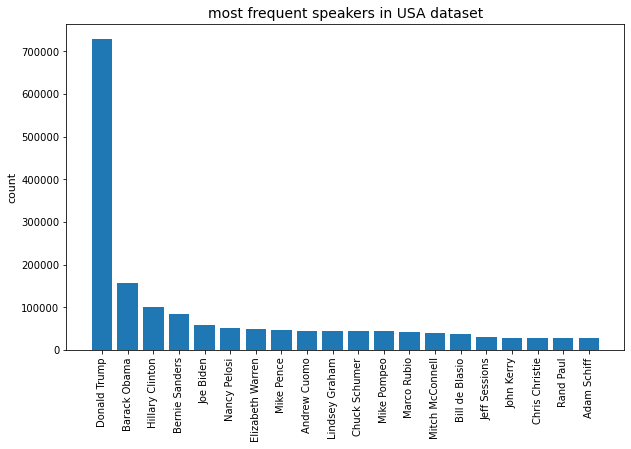

In [4]:
#plotting usa speakers distribution
counts_USA=Counter(all_qids_USA)
N_politicians_USA=len(counts_USA)
print(f'Total number of speakers in USA dataset: {N_politicians_USA}')

most_frequents_USA=counts_USA.most_common(20)
qids_USA=[i[0] for i in most_frequents_USA]
names_USA=[qids_df.loc[qids_df.qid == qid, 'name'].item() for qid in qids_USA]
N=[i[1] for i in most_frequents_USA]
plt.figure(figsize=(10,6))
plt.title('most frequent speakers in USA dataset', fontsize=14)
plt.bar(names_USA,N)
plt.ylabel('count',fontsize=11)
plt.xticks(rotation = 90)
plt.show()

Some politicians tend to mention other politicians more often, we find insteresting to identify the central node of political networks. We observed Donald Trump's quotations are very present in the media compared to the others, he could be potentialy a central hub for the political network.

In [5]:
#only keeping qids of interest from catalogue for code efficiency
qids_count_USA=[item for item in counts_USA]
qids_df_USA=qids_df[qids_df['qid'].isin(qids_count_USA)]

We retrieve the parties information for each speaker from our catalogue ([see Politician Filter notebook](https://github.com/epfl-ada/ada-2021-project-date-a-data/blob/main/Milestone2/Politician%20Filter.ipynb))

In [6]:
#retrieving parties information for each speaker in USA dataset
parties=[]
for i, speaker_qid in enumerate(counts_USA):
    parties.extend(qids_df_USA.loc[qids_df_USA.qid == speaker_qid, 'parties'].item())
parties_count=Counter(parties)
sorted_parties_count=sorted(parties_count.items(), key=lambda x: x[1], reverse=True)


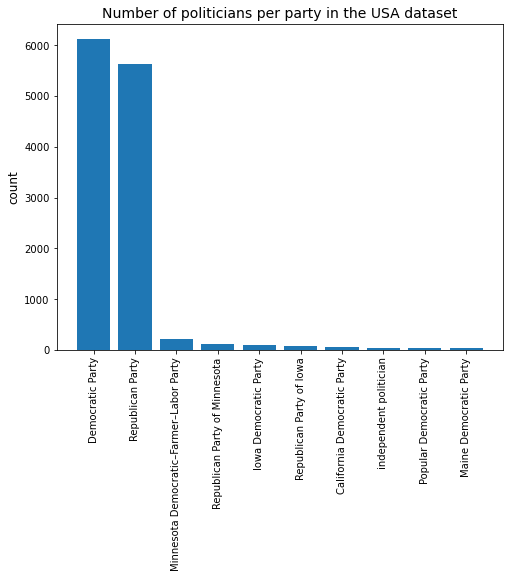

In [7]:
#plotting number of politician per party in USA dataset
parties=[x[0] for x in sorted_parties_count][:10]
counts=[x[1] for x in sorted_parties_count][:10]
plt.figure(figsize=(8,6))
plt.bar(parties,counts)
plt.xticks(rotation = 90)
plt.title('Number of politicians per party in the USA dataset',fontsize=14)
plt.ylabel('count',fontsize=12)
plt.show()

For now, we can observe 2 main parties in our data, Democratic and Republican. The other parties are less present, we will check if there is enough data from the mention quotations. 

After the preprocessing, we obtain the different mentions of USA politics from QUOTEBANK. 

In the following code : 

we decide to check if we have enough data, from the parties/speakers we are interested to make a US mentions network.

In [1]:
USA_MENTIONS = 'quotebank_politicians_USA_mapped.json.bz2'

In [5]:
mentions_usa_df=pd.read_json(USA_MENTIONS,compression='bz2', lines=True)

In [8]:
counts_USA_mentions=Counter(mentions_usa_df.qids.str[0])
N_mentions_USA=len(counts_USA_mentions)
print(f'Total number of USA speakers mentioning other politicien in 2020: {N_mentions_USA}')

Total number of USA speakers mentioning other politicien in 2020: 1581


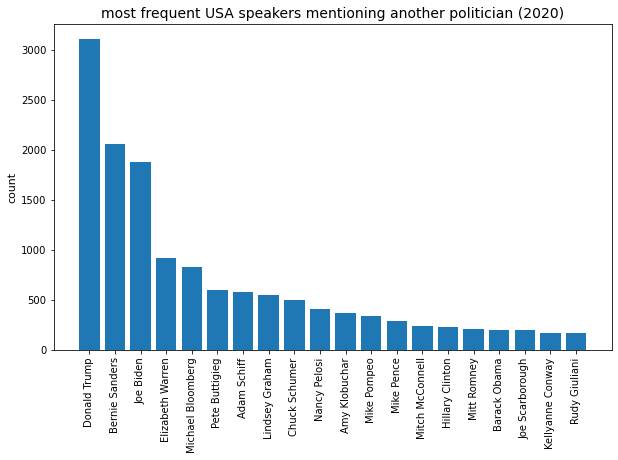

In [9]:
#plotting the most frequent USA speakers mentioning another politician (2020 shown)
most_speakers=counts_USA_mentions.most_common(20)
qids_USA_mentions=[i[0] for i in most_speakers]
qids_count_USA_mentions=[item for item in counts_USA_mentions]
qids_df_USA_mentions=qids_df[qids_df['qid'].isin(qids_count_USA_mentions)]
names_USA_mentions=[qids_df.loc[qids_df.qid == qid, 'name'].item() for qid in qids_USA_mentions]
N=[i[1] for i in most_speakers]
plt.figure(figsize=(10,6))
plt.title('most frequent USA speakers mentioning another politician (2020)', fontsize=14)
plt.bar(names_USA_mentions,N)
plt.ylabel('count',fontsize=11)
plt.xticks(rotation = 90)
plt.show()

Indeed, we see even if Donald Trump is still more present, there is less differences to the others. multiple central hub could be used to create the political network.

In [10]:
#retrieving parties information for USA politician mentioning another 
parties=[]
for i, speaker_qid in enumerate(counts_USA_mentions):
    parties.extend(qids_df_USA_mentions.loc[qids_df_USA_mentions.qid == speaker_qid, 'parties'].item())
parties_count_mentions=Counter(parties)
sorted_parties_count_mentions=sorted(parties_count_mentions.items(), key=lambda x: x[1], reverse=True)

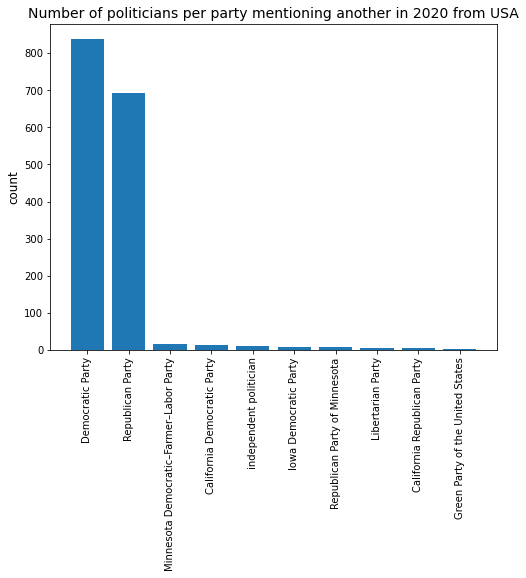

In [11]:
#plotting number of USA politician mentioning
parties=[x[0] for x in sorted_parties_count_mentions][:10]
counts=[x[1] for x in sorted_parties_count_mentions][:10]
plt.figure(figsize=(8,6))
plt.bar(parties,counts)
plt.xticks(rotation = 90)
plt.title('Number of politicians per party mentioning another in 2020 from USA',fontsize=14)
plt.ylabel('count',fontsize=12)
plt.show()

No representative difference is observed from the politician parties, there is still the 2 main parties (Democratic and Republican). Meaning they tend to mentions much more others parties (or themselves).

### 2) WORLD dataset
We did some analysis about the WORLD dataset, to see the politician speaker distribution on the WORLD dataset :

In [9]:
#iterating trough WORLD dataset and retrieving speakers qids
all_qids_WORLD=[]
with pd.read_json(QUOTEBANK_POLITICIANS_WORLD, lines=True, chunksize=CHUNKSIZE,compression='bz2') as df_reader:
    Nchunk=0
    for chunk in df_reader:
        all_qids_WORLD.extend(chunk.qids.str[0])
        Nchunk+=1
        #print(f'chunk {Nchunk} in {150}')

Then we plot the speaker distribution from the WORLD dataset.

Total number of speakers in USA dataset: 54464


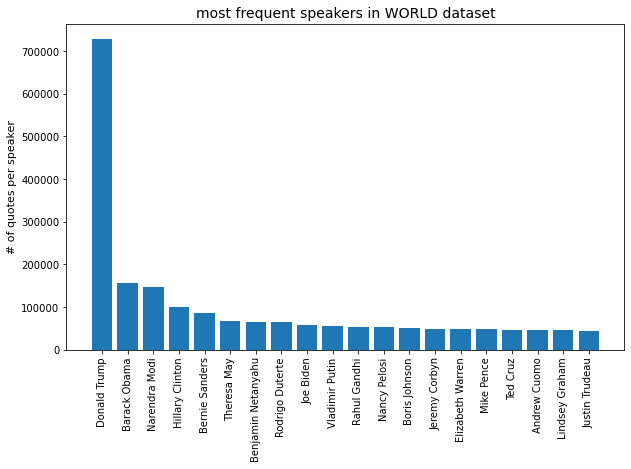

In [10]:
#plotting speaker distribution
counts_WORLD=Counter(all_qids_WORLD)
N_politicians_WORLD=len(counts_WORLD)
print(f'Total number of speakers in USA dataset: {N_politicians_WORLD}')
most_frequents_WORLD=counts_WORLD.most_common(20)
qids_WORLD=[i[0] for i in most_frequents_WORLD]
names_WORLD=[qids_df.loc[qids_df.qid == qid, 'name'].item() for qid in qids_WORLD]
N=[i[1] for i in most_frequents_WORLD]
plt.figure(figsize=(10,6))
plt.title('most frequent speakers in WORLD dataset', fontsize=14)
plt.bar(names_WORLD,N)
plt.ylabel('# of quotes per speaker',fontsize=11)
plt.xticks(rotation = 90)
plt.show()

We see Donald Trump is still the top ONE speakers during the last 5 years. It is expected as the quotations are from the english news, we observed that most frequent speaker are in general from USA.